***HIREVISION; INTEGRANTES: LUCAS MORALES, LUCAS CHACÓN Y AXEL GONZÁLEZ***

Cargamos el frame y creamos uno nuevo con las variables que nos interesan, para esta primera aproximación a nuestro modelo final decidimos utilizar solo variables numéricas o binarias, para la entrega final consideraremos también si es que son influyentes las variables  de tipo string.

LINK DATASET: https://drive.google.com/drive/folders/1MFq-KvPqzjz_9Wr9i8yn6yXuS7HOr-T-?usp=drive_link

RESUMEN DE NUESTRO PROYECTO: Inicialmente, el proyecto se centraba en abordar la falta de visibilidad de las ofertas de empleo mediante el análisis de descripciones mal redactadas, lo que representaba un desafío para los departamentos de Recursos Humanos al dificultar la atracción de candidatos adecuados. La solución original proponía un enfoque basado en dos herramientas: un modelo de análisis de texto para examinar la calidad de las descripciones y una regresión lineal para predecir el número de vistas de una oferta en función de las características textuales y otros atributos.

Sin embargo, durante el desarrollo del proyecto, identificamos que el modelo de regresión lineal no se ajustaba de manera óptima a la naturaleza de los datos, ya que la variable de interés, el número de vistas, es un conteo de eventos que no puede tomar valores negativos y suele tener una distribución sesgada hacia la derecha. Por ello, optamos a mediados de nuestro proyecto por emplear un modelo de regresión de Poisson, que se ajusta mejor a datos de conteo y nos permite hacer predicciones más precisas en términos de vistas de las ofertas.

No obstante, al profundizar en el análisis, detectamos que los datos presentan una sobre-dispersión significativa, lo que significa que la varianza es mayor que la media, algo que el modelo de Poisson no puede capturar adecuadamente y que además era uno de sus supuestos. Por esta razón, finalmente decidimos emplear una regresión binomial negativa, que es más adecuada para manejar esta característica de los datos y nos permite obtener resultados más robustos y realistas.

A continuación se presenta nuestro código y algunas explicaciones asociadas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/CASO LINKEDIN/LinkedInJobs_MLDataset.csv")
data.head()


relevant_features = ['Emp_Cnt', 'Flw_Cnt', 'med_sal', 'is_remote', 'is_sponsored', 'base_comp', 'views']  # Incluimos 'views' como variable dependiente
new_df = data[relevant_features]
new_df.head()


Mounted at /content/drive


,Emp_Cnt,Flw_Cnt,med_sal,is_remote,is_sponsored,base_comp,views
0,1171,11417,5250.00,0,0,1,9
1,300,2923,0.00,0,0,0,0
2,314,8487,0.00,0,0,0,0
3,36,305,22.27,0,0,1,1
4,1227,51933,240895.00,1,0,1,0


En el bloque anterior desarrollamos una selección de las variables relevantes para utilizar en el proyecto, y ahora en base a dispersión y nuestra matriz de correlación determinamos cuáles utlizamos

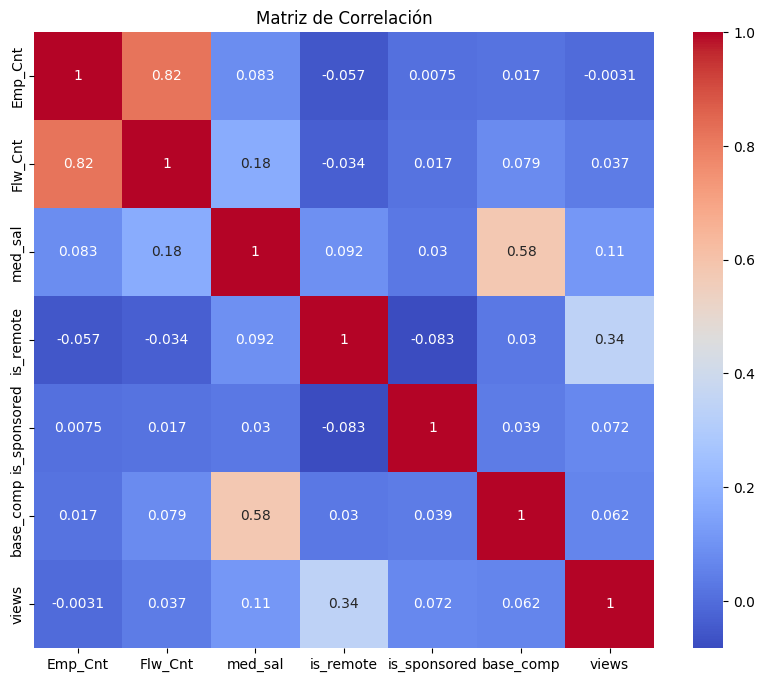

In [4]:
correlation_matrix = new_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

 Las correlaciones más relevantes son entre is_remote y views (0.34), indicando que los trabajos remotos podrían influir en el número de vistas, y med_sal y views (0.11), lo que sugiere una ligera relación positiva entre el salario y las vistas. También destaca una correlación alta entre Emp_Cnt y Flw_Cnt (0.82), lo que podría indicar redundancia o multicolinealidad entre estas variables, algo a considerar al incluirlas en el modelo. En general, las correlaciones bajas refuerzan la necesidad de un modelo adecuado para capturar patrones no lineales o complejos.

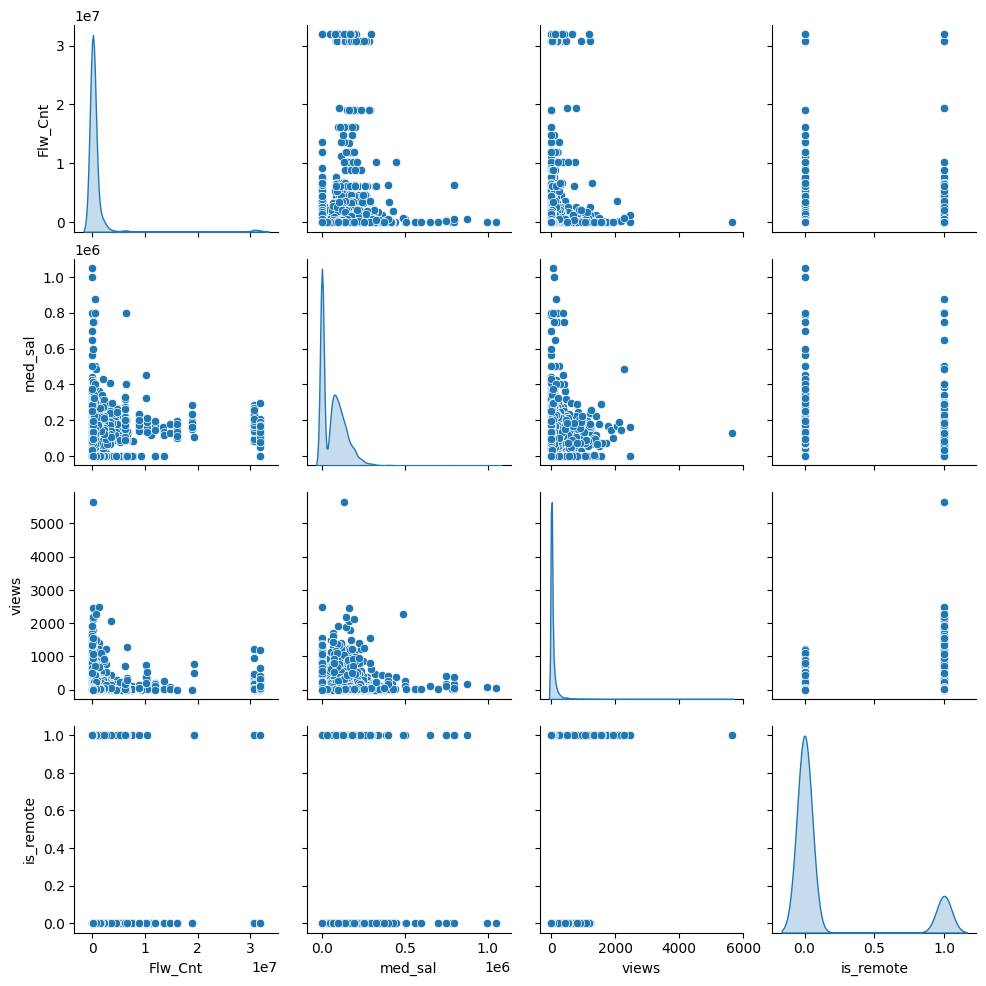

In [5]:
df = data[['Flw_Cnt', 'med_sal', 'views', 'is_remote']]
df = df[df['med_sal'] > 0]
sns.pairplot(df, diag_kind="kde")
plt.show()

 Se observa que la variable views tiene una distribución sesgada hacia valores bajos, mientras que variables como Flw_Cnt y med_sal muestran patrones dispersos y concentraciones en valores específicos. Además, la variable is_remote es binaria, lo que divide los datos en dos grupos claramente diferenciados. Las distribuciones univariadas sugieren que los datos están fuertemente sesgados en varias dimensiones, lo que refuerza la necesidad de un modelo como la regresión binomial negativa para capturar adecuadamente estas características.

Por decisión propia y basada en algunas pruebas que realizamos con nuestra base de datos(realización de regresiones simples para cada variable) seleccionamos 3 variables independientes, Flw_Cnt, med_sal y is_remote para crear un modelo capaz de predecir la cantidad de views que en este caso se consideraría la variable dependiente, además considerando que no todas las empresas publican su salario medio, utilizaremos para nuestro análisis solo las que si lo hicieron

Lo primero que realizarémos será estimar el valor de alpha para nuestro modelo de regresión binomial negativa, este parámetro que se mueve entre 0 y 1 y indica que tan sobredispersos están nuestros datos.

In [6]:
X = df.drop("views", axis=1)
y = df.views
nomb_caract = X.columns.to_list()
standizer = StandardScaler()
X = standizer.fit_transform(X)
aux_model = smf.glm(formula="views ~ Flw_Cnt + med_sal + is_remote",
                      data=df,
                      family=sm.families.Poisson()).fit()
alpha_est = aux_model.scale
print(f"Estimación inicial de alpha: {alpha_est}")

Estimación inicial de alpha: 1.0


Una vez ya estimado el valor, utilizamos nuestra regresión binomial negativa

In [7]:
X = df.drop("views", axis=1)
y = df.views
nomb_caract = X.columns.to_list()

# escala las características (variables)
standizer = StandardScaler()
X = standizer.fit_transform(X)

model = smf.glm(formula="views ~ Flw_Cnt + med_sal + is_remote",
                data=df,
                family=sm.families.NegativeBinomial(alpha=1))

# Ajusta el modelo a los datos
results = model.fit()
results.summary(xname=['Intercepto'] + nomb_caract)
# Imprime los resultados
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  views   No. Observations:                13350
Model:                            GLM   Df Residuals:                    13346
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63199.
Date:                Tue, 19 Nov 2024   Deviance:                       39328.
Time:                        03:51:31   Pearson chi2:                 5.46e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4310
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1226      0.012    254.197      0.0

Interpretación de la salida de la regresión
1. Coeficientes y p-valores
    Coeficiente (coef):
    Este valor indica el cambio en el logaritmo de las predicciones del modelo cuando la variable predictora aumenta en una unidad, manteniendo las demás constantes. En este caso:

    Flw_Cnt (número de seguidores): Un aumento de una unidad en Flw_Cnt está asociado con un incremento promedio de
    2.623
    ×
    1
    0
    −
    8
    2.623×10
    −8
      en el logaritmo de las vistas de la oferta.
    med_sal (salario medio): Tiene un coeficiente de
    4.761
    ×
    1
    0
    −
    6
    4.761×10
    −6
    , lo que sugiere que un incremento unitario en el salario medio incrementa el logaritmo de las vistas en esa magnitud.
    is_remote: Un coeficiente de 1.5956 indica que las ofertas de empleo remotas están asociadas con un aumento significativo en el logaritmo de las visualizaciones.
    Error estándar (std err):
    Representa la variabilidad en la estimación de cada coeficiente. Valores bajos, como los observados en esta salida, indican alta precisión en las estimaciones:

    Todos los errores estándar son pequeños, particularmente para Flw_Cnt (
    2.42
    ×
    1
    0
    −
    9
    2.42×10
    −9
    ) y med_sal (
    1.21
    ×
    1
    0
    −
    7
    1.21×10
    −7
    ), lo que respalda la confianza en sus coeficientes.
    Valor z:
    Es la relación entre el coeficiente y su error estándar. Valores altos sugieren que los coeficientes son significativamente distintos de cero. Aquí:

    Los valores z son muy altos para todas las variables (por ejemplo, 65.924 para is_remote), lo que indica una fuerte relación entre cada predictor y la variable dependiente.
    p-valor (P>|z|):
    Indica la probabilidad de observar un valor z tan extremo bajo la hipótesis nula de que el coeficiente es cero. Un p-valor bajo (<0.05) sugiere significancia estadística:

    Todos los p-valores son 0.000, confirmando que cada variable es estadísticamente significativa.
    Intervalo de confianza [0.025, 0.975]:
    Proporciona un rango donde se espera que se encuentre el verdadero valor del coeficiente con un 95% de confianza:

    Por ejemplo, el coeficiente de is_remote está entre 1.548 y 1.643, mostrando precisión y significancia en su estimación.
2. Bondad de ajuste (análisis de la eficacia del modelo)
    Chi-cuadrado de Pearson:
    Esta estadística mide la discrepancia entre los valores observados y los valores predichos por el modelo. Aquí:

    El valor
    5.46
    ×
    1
    0
    4
    5.46×10
    4
    podría indicar una cierta discrepancia
    Deviance del modelo:
    Una deviance de 39328 refleja el ajuste del modelo en comparación con el modelo nulo. Este valor debe interpretarse en contexto, considerando el número de observaciones.

    Pseudo R-cuadrado:
    Representa qué tan bien el modelo explica la variabilidad de los datos en comparación con el modelo nulo:

    Un valor de 0.4310 indica que el modelo captura aproximadamente el 43.1% de la variabilidad en las vistas de las ofertas.
  

Conclusión
El modelo muestra significancia estadística en todas las variables predictoras, y los coeficientes son consistentes y precisos, si bien hay detalles a mejorar, por la naturaleza de los datos necesitaría de un análisis mucho mas profundo, debido a la dependencia de las views de una oferta de empleo por demasiados factores.

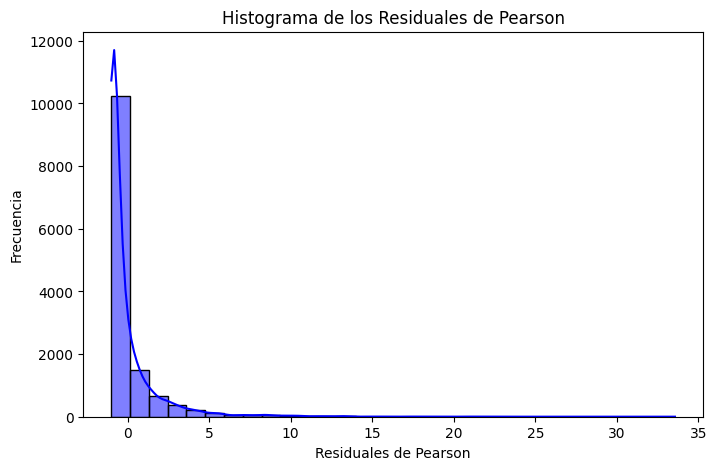

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pearson_residuals = results.resid_pearson
fitted_values = results.fittedvalues

plt.figure(figsize=(8, 5))
sns.histplot(pearson_residuals, kde=True, bins=30, color="blue")
plt.title("Histograma de los Residuales de Pearson")
plt.xlabel("Residuales de Pearson")
plt.ylabel("Frecuencia")
plt.show()


En una regresión binomial negativa, los residuos de Pearson miden la discrepancia entre los valores observados y los valores ajustados, considerando la varianza esperada bajo este modelo. No se espera que sigan una distribución normal, pero deberían tener un comportamiento razonable

Una regresión binomial negativa debe cumplir con los siguientes supuestos:

Variable dependiente de conteo: La variable dependiente debe representar conteos de eventos no negativos (por ejemplo, el número de vistas, ocurrencias o visitas).

Sobredispersión: A diferencia de la regresión de Poisson, este modelo asume que los datos tienen sobredispersión, lo que significa que la varianza es mayor que la media. Este supuesto lo hace adecuado para datos donde la regresión de Poisson falla.

Distribución de la variable dependiente: La variable dependiente sigue una distribución binomial negativa, que modela la relación entre media y varianza mediante un parámetro adicional de dispersión.

Independencia de las observaciones: Se asume que las observaciones son independientes entre sí, lo que significa que el número de eventos en una observación no afecta el número en otra.

Efectos multiplicativos: El efecto de las variables independientes sobre la variable dependiente es exponencial, ya que utiliza una función de enlace logarítmica.

No multicolinealidad severa: Las variables independientes no deben estar altamente correlacionadas, ya que esto puede distorsionar los coeficientes estimados.

Especificación correcta del modelo: El modelo debe incluir todas las variables relevantes y excluir aquellas irrelevantes para evitar sesgos en las estimaciones.

Con el cálculo de alpha en el principio del proyecto validamos todos los supuestos y confirmamos la existencia de sobredisperción

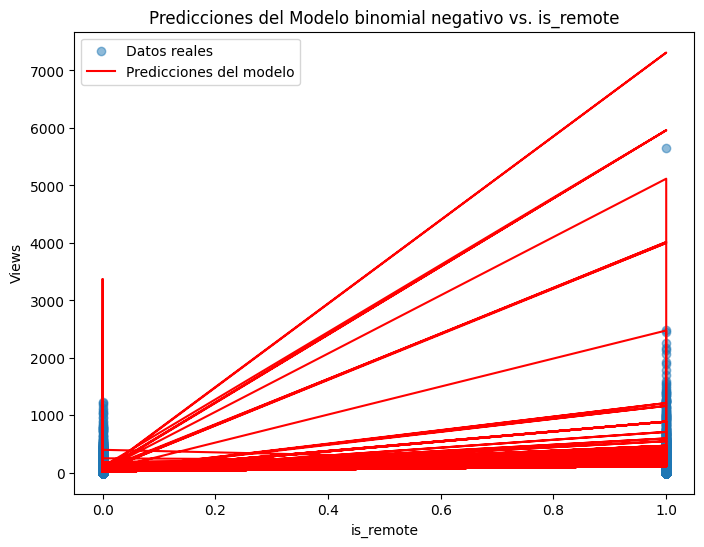

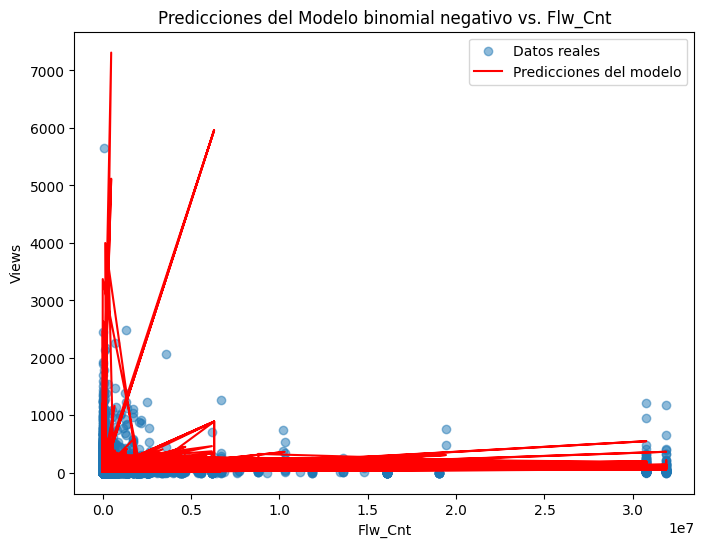

In [9]:
#GRÁFICAS
y_pred = results.predict()

fig1, ax1 = plt.subplots(figsize=(8, 6))
fig2, ax2 = plt.subplots(figsize=(8, 6))

ax1.scatter(df['is_remote'], y, label="Datos reales", alpha=0.5)
ax1.plot(df['is_remote'], y_pred, color='red', label="Predicciones del modelo")
ax1.set_xlabel('is_remote')
ax1.set_ylabel('Views')
ax1.set_title('Predicciones del Modelo binomial negativo vs. is_remote')
ax1.legend()

ax2.scatter(df['Flw_Cnt'], y, label="Datos reales", alpha=0.5)
ax2.plot(df['Flw_Cnt'], y_pred, color='red', label="Predicciones del modelo")
ax2.set_xlabel('Flw_Cnt')
ax2.set_ylabel('Views')
ax2.set_title('Predicciones del Modelo binomial negativo vs. Flw_Cnt')
ax2.legend()

plt.show()

***Entrenamiento y validación***

Primero separaremos los conjuntos

In [10]:
from sklearn.model_selection import train_test_split

features = [i for i in df.columns if i != "views"]
target = "views"

train, test = train_test_split(df, test_size=0.10, train_size=0.90, random_state=42)

train, validation = train_test_split(train, test_size=0.2, train_size=0.80, random_state=42)

print(f"Train shape: {train.shape}, Validation shape: {validation.shape}, Test shape: {test.shape}")


Train shape: (9612, 4), Validation shape: (2403, 4), Test shape: (1335, 4)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_val = scaler.transform(validation[features])
X_test = scaler.transform(test[features])

X_train_exog = sm.add_constant(X_train)
X_val_exog = sm.add_constant(X_val)
X_test_exog = sm.add_constant(X_test)

neg_binom_model = sm.GLM(train[target], X_train_exog, family=sm.families.NegativeBinomial(alpha = 1))
result = neg_binom_model.fit()

# Resumen del modelo
print(result.summary(xname=['Intercepto'] + features))

# Evaluación en el conjunto de entrenamiento
print("*********Training Set Metrics**************")
train_predictions = result.predict(X_train_exog)
train_mse = ((train[target] - train_predictions) ** 2).mean()
print("MSE (Training):", train_mse)

# Evaluación en el conjunto de validación
print("********Validation Set Metrics**************")
val_predictions = result.predict(X_val_exog)
val_mse = ((validation[target] - val_predictions) ** 2).mean()
print("MSE (Validation):", val_mse)

# Evaluación en el conjunto de prueba
print("********Test Set Metrics**************")
test_predictions = result.predict(X_test_exog)
test_mse = ((test[target] - test_predictions) ** 2).mean()
print("MSE (Test):", test_mse)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  views   No. Observations:                 9612
Model:                            GLM   Df Residuals:                     9608
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -45557.
Date:                Tue, 19 Nov 2024   Deviance:                       28285.
Time:                        03:52:11   Pearson chi2:                 4.05e+04
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4429
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercepto     3.7254      0.010    360.009      0.0

El modelo es estadísticamente significativo, y los coeficientes indican relaciones importantes entre las variables predictoras y la variable dependiente. Sin embargo, la diferencia en los valores de MSE entre los conjuntos de validación y prueba sugiere que podría beneficiarse de ajustes adicionales

RECOMENDACIONES:

Para aumentar las "views" de las ofertas de trabajo en LinkedIn, recomendamos una serie de estrategias basadas en los resultados de nuestro modelo y nuestra experiencia en el desarrollo de esta herramienta.

1. Optimizar el número de seguidores de la empresa (Flw_Cnt):
Resultado del modelo: Un pequeño incremento en el número de seguidores de la empresa tiene un impacto positivo, aunque leve, en el número de vistas de las ofertas.
Recomendación:
Fomentar campañas de marketing para aumentar los seguidores en LinkedIn, como compartir contenido relevante y participar en conversaciones de la industria.
Incluir llamadas a la acción en publicaciones que inviten a los usuarios a seguir la página de la empresa.
2. Ofrecer salarios competitivos (med_sal):
Resultado del modelo: El salario promedio está positivamente asociado con un aumento significativo en las vistas.
Recomendación:
Incluir rangos salariales claros y atractivos en las ofertas. Esto no solo aumenta las vistas, sino también la calidad de los postulantes.
Realizar estudios de mercado para ofrecer salarios alineados con las expectativas de los candidatos y las tendencias del sector.
3. Promover el trabajo remoto (is_remote):
Resultado del modelo: Las ofertas de empleo remoto tienen un impacto considerable en el aumento de vistas.
Recomendación:
Priorizar la publicación de empleos remotos o híbridos siempre que sea posible.
Resaltar los beneficios del trabajo remoto, como flexibilidad y conciliación vida-trabajo, en las descripciones de los puestos.
